# **Notebook 11.2: Residual Networks**

This notebook adapts the networks for MNIST1D to use residual connections.

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.



In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
!pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-7lxr2eex
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-7lxr2eex
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14663 sha256=e3afa40ae2c5432881ad75beb991b6924290bb0b4014f67fbb68d6d36581ff48
  Stored in directory: /tmp/pip-ephem-wheel-cache-t9yw0455/wheels/18/40/b6/29381fee9b4c80fdbc304d52bb065a7286bbcca5ca2b8737c0
Successfully built mnist1d


In [2]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import random

In [3]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [4]:
# Load in the data
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)


Define the network

In [5]:
# There are 40 input dimensions and 10 output dimensions for this data
# The inputs correspond to the 40 offsets in the MNIST1D template.
D_i = 40
# The outputs correspond to the 10 digits
D_o = 10


# We will adapt this model to have residual connections around the linear layers
# This is the same model we used in practical 8.1, but we can't use the sequential
# class for residual networks (which aren't strictly sequential).  Hence, I've rewritten
# it as a model that inherits from a base class

class ResidualNetwork(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(ResidualNetwork, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.linear4 = nn.Linear(hidden_size, output_size)
    print("Initialized MLPBase model with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

# TODO -- Add residual connections to this model
# The order of operations within each block should similar to figure 11.5b
# ie., linear1 first, ReLU+linear2 in first residual block, ReLU+linear3 in second residual block), linear4 at end
# Replace this function
  def forward(self, x):
    h = self.linear1(x)
    h = h + self.linear2(h.relu())
    h = h + self.linear3(h.relu())
    out = self.linear4(h)
    return out


In [6]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [10]:
#Define the model
model = ResidualNetwork(40, 10)

# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
# convert data to torch tensors
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long'))
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 250
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_val = np.zeros((n_epoch))
errors_val = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, data in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_val = model(x_val)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_val[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Initialized MLPBase model with 25310 parameters
Epoch     0, train loss 1.598676, train error 59.42,  val loss 1.745014, percent error 66.50
Epoch     1, train loss 1.186977, train error 44.05,  val loss 1.343320, percent error 51.60
Epoch     2, train loss 1.014463, train error 39.17,  val loss 1.156267, percent error 44.20
Epoch     3, train loss 0.963492, train error 36.65,  val loss 1.165302, percent error 43.70
Epoch     4, train loss 0.805440, train error 31.00,  val loss 1.076072, percent error 41.40
Epoch     5, train loss 0.740150, train error 28.45,  val loss 1.140142, percent error 40.20
Epoch     6, train loss 0.733668, train error 27.85,  val loss 1.146797, percent error 41.50
Epoch     7, train loss 0.650138, train error 24.93,  val loss 1.157754, percent error 41.00
Epoch     8, train loss 0.613727, train error 23.62,  val loss 1.171456, percent error 39.80
Epoch     9, train loss 0.465961, train error 17.47,  val loss 1.066695, percent error 35.80
Epoch    10, train los

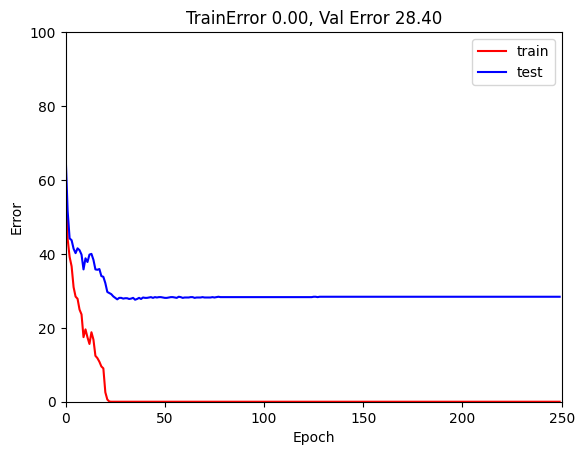

In [11]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Val Error %3.2f'%(errors_train[-1],errors_val[-1]))
ax.legend()
plt.show()

The primary motivation of residual networks is to allow training of much deeper networks.   

TODO: Try running this network with and without the residual connections.  Does adding the residual connections change the performance?